<h1 align="center">IBM Applied Data Science Capstone</h1>
<h2 align="center">Battle of the Neighbourhoods</h2>
<h2 align="center">Paris and London</h2>

<img src="paris.jpg" width=400 height=600 /><img src="london.jpg" width=400 height=600 />

# 1. Introduction and Business Problem

The purpose of this project is to help tourists choose their destinations depending on what experiences the neighbourhoods have to offer and what the neighbourhoods would want to have. This also helps people make decisions if they are thinking about migrating to Paris or London or even if they want to relocate between neighbourhoods within the city.  

It also will help people to get awareness of the area and neighborhood before moving to a new city, state, country or place for their work or to start a new fresh life. Our findings will help stakeholders make informed decisions and address any concerns they have including the different kinds of cuisines, provision stores and what the city has to offer.

### Work Flow
Using credentials of Foursquare API features of near-by places of the neighborhoods would be mined. Due to http request limitations the number of places per neighborhood parameter would reasonably be set to 100 and the radius parameter would be set to 500.

### Clustering Approach
To compare the similarities of two cities, we decided to explore neighborhoods, segment them, and group them into clusters to find similar neighborhoods in a big city. To be able to do that, we need to cluster data which is a form of unsupervised machine learning: k-means clustering algorithm


# 2. Data Description

We require geolocation data for both Paris and London. Postal codes in each city serve as a starting point. Using Postal codes we can find out the neighbourhoods, boroughs, venues and their most popular venue categories.

## Paris

To derive our solution, We scrape our data from https://www.data.gouv.fr/fr/datasets/r/e88c6fda-1d09-42a0-a069-606d3259114e 

The JSON file has data about all the neighbourhoods in France, we limit it only Paris.

1. *postal_code* : Postal codes for France
2. *nom_comm* : Name of Neighbourhoods in France
3. *nom_dept* : Name of the boroughs, equivalent to towns in France
4. *geo_point_2d* : Tuple containing the latitude and longitude of the Neighbourhoods.

## London

To derive our solution, We scrape our data from https://en.wikipedia.org/wiki/List_of_areas_of_London

This wikipedia page has information about all the neighbourhoods, we limit it only London.

1. *borough* : Name of Neighbourhood
2. *town* : Name of borough
3. *post_code* : Postal codes for London.

This wikipedia page lacks information about the geographical locations. To solve this problem we use ArcGIS API

### ArcGIS API

ArcGIS Online enables us to connect people, locations, and data using interactive maps. Work with smart, data-driven styles and intuitive analysis tools that deliver location intelligence. Share your insights with the world or specific groups. We use ArcGIS to get the geo locations of the neighbourhoods of London. The following columns are added to our initial dataset which prepares our data. 

4. *latitude* : Latitude for Neighbourhood
5. *longitude* : Longitude for Neighbourhood
    
Based on all the information collected for both Paris and London, we have sufficient data to build our model. We cluster the neighbourhoods together based on similar venue categories. We then present our observations and findings. Using this data, our stakeholders can take the necessary decision.

## Foursquare API Data

We will need data about different venues in different neighbourhoods of that specific borough. In order to obtain information we use "Foursquare" locational information. Foursquare is a location data provider with information about all manner of venues and events within an area of interest. Such information includes venue names, locations, menus and even photos. As such, the foursquare location platform will be used as the sole data source since all the stated required information can be obtained through the API.

After finding the list of neighbourhoods, we then connect to the Foursquare API to gather information about venues inside each and every neighbourhood. For each neighbourhood, we have chosen the radius to be 500 meters. The data retrieved from Foursquare contained information of venues within a specified distance of the longitude and latitude of the postcodes. The information obtained per venue as follows:

1. *Neighbourhood* : Name of the Neighbourhood
2. *Neighbourhood Latitude* : Latitude of the Neighbourhood
3. *Neighbourhood Longitude* : Longitude of the Neighbourhood
4. *Venue* : Name of the Venue
5. *Venue Latitude* : Latitude of Venue
6. *Venue Longitude* : Longitude of Venue
7. *Venue Category* : Category of Venue

## Libraries Which are Used to Develope the Project:
Pandas: For creating and manipulating dataframes.

Folium: Python visualization library would be used to visualize the neighborhoods cluster distribution of using interactive leaflet map.

Scikit Learn: For importing k-means clustering.

Matplotlib: Python Plotting Module.

# 3. Methodology

We will be creating our model with the help of Python so we start off by importing all the required packages.

import pandas as pd
import requests
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium

#import k-means for the clustering stage
from sklearn.cluster import KMeans

import sys
!conda install --yes --prefix {sys.prefix} -c esri arcgis
from arcgis.geocoding import geocode
from arcgis.gis import GIS
gis = GIS()

The approach taken here is to explore each of the cities individually, plot the map to show the neighbourhoods being considered and then build our model by clustering all of the similar neighbourhoods together and finally plot the new map with the clustered neighbourhoods. We draw insights and then compare and discuss our findings.

# Exploring Paris

### Data Collection

We read the json data with pandas.

paris_raw = pd.read_json('france-data.json')
paris_raw.head()

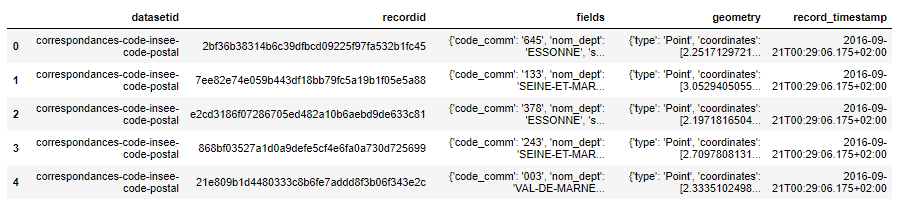

### Data Preprocessing
We break down each of the nested fields and create the dataframe that we need

paris_field_data = pd.DataFrame()
for f in paris_raw.fields:
    dict_new = f
    paris_field_data = paris_field_data.append(dict_new, ignore_index=True)

paris_field_data.head()

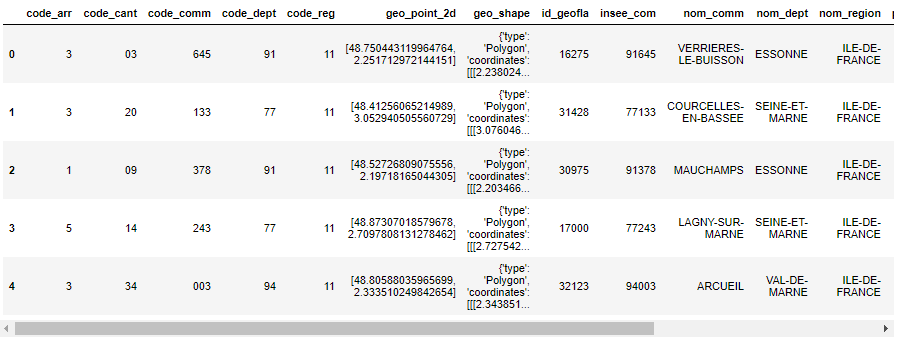

### Feature Selection
We take the columns that we require, in case of paris it would be the geo_point_2d, nom_dept, nom_comm and postal_code

df_paris = paris_field_data[['postal_code','nom_comm','nom_dept','geo_point_2d']]
df_paris

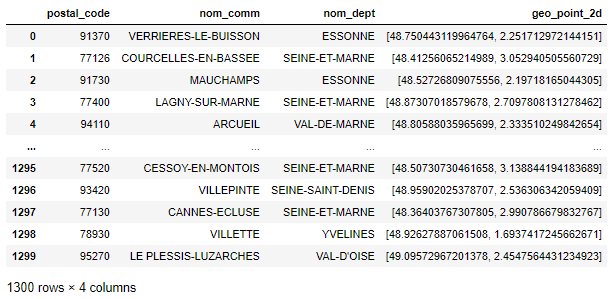

### Feature Engineering
We localize to only include Paris

df_paris = df_paris[df_paris['nom_dept'].str.contains('PARIS')].reset_index(drop=True)
df_paris

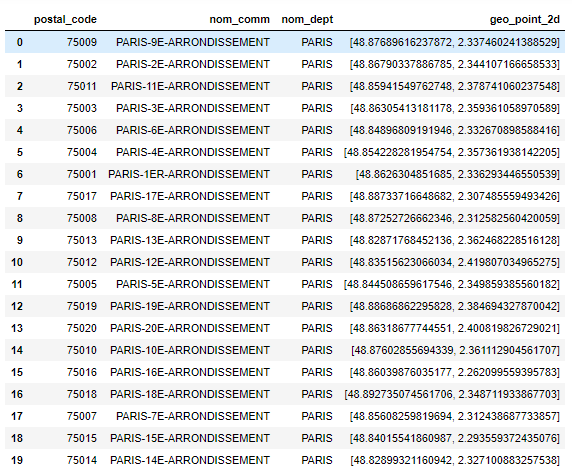

### Gelocations of the Neighbourhoods of Paris
We don't need to get the geo coordinates using an external data source or collect it with the arcgis API call since we already have it stored in the *geo_point_2d* column as a tuple in the *df_paris* dataframe.

temp1 = df_paris['geo_point_2d']
temp1

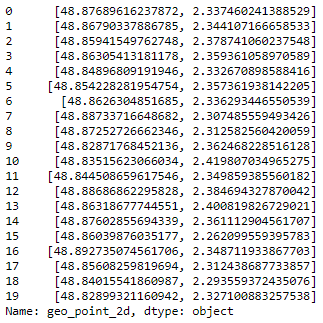

paris_latlng = df_paris['geo_point_2d'].astype('str')

Spliting the geo_point_2d column into latitude and longitude.

#### Latitude

paris_lat = paris_latlng.apply(lambda x: x.split(',')[0])
paris_lat = paris_lat.apply(lambda x: x.lstrip('['))
paris_lat

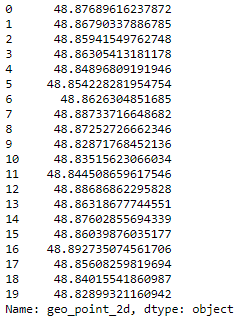

#### Longitude

paris_lng = paris_latlng.apply(lambda x: x.split(',')[1])
paris_lng = paris_lng.apply(lambda x: x.rstrip(']'))
paris_lng

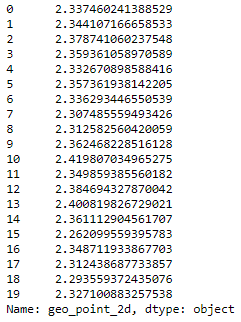

paris_geo_lat  = pd.DataFrame(paris_lat.astype(float))
paris_geo_lat.columns=['Latitude']
paris_geo_lng = pd.DataFrame(paris_lng.astype(float))
paris_geo_lng.columns=['Longitude']

paris_combined_data = pd.concat([df_paris.drop('geo_point_2d', axis=1), paris_geo_lat, paris_geo_lng], axis=1)
paris_combined_data

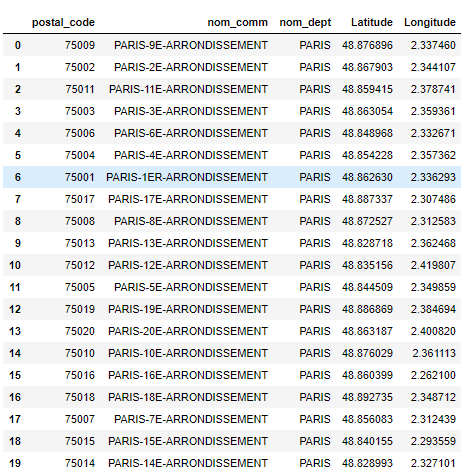

### Co-ordinates for Paris

paris = geocode(address='Paris, France, FR')[0]
paris_lng_coords = paris['location']['x']
paris_lat_coords = paris['location']['y']
print("The geolocation of Paris: ", paris_lat_coords, paris_lng_coords)

output : The geolocation of Paris:  48.85341000000005 2.3488000000000397

### Visualize the Map of Paris

#Creating the map of Paris
map_Paris= folium.Map(location=[paris_lat_coords, paris_lng_coords], zoom_start=12)
map_Paris

#adding markers to map
for latitude, longitude, borough, town in zip(paris_combined_data['Latitude'], paris_combined_data['Longitude'], paris_combined_data['nom_comm'], paris_combined_data['nom_dept']):
    label = '{}, {}'.format(town, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='Blue',
        fill=True,
        fill_opacity=0.8
        ).add_to(map_Paris)  
    
map_Paris

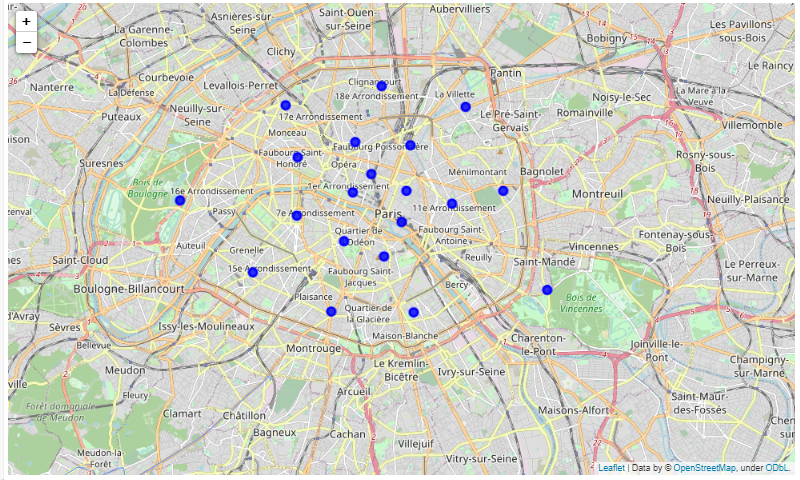

### Venues in Paris
To proceed with the next part, we need to define Foursquare API credentials.
Using Foursquare API, we are able to get the venue and venue categories around each neighbourhood in Paris.

CLIENT_ID = 'MW0HNMAAVZ2AHN2GJQVRURBGN5HEORAR0EVEYMKI10WYYNNM'
CLIENT_SECRET = 'DQ1ZEWFMCBKBC0311AJQE1T3HNSTQRP1RDVWOFZCVYLS20DB'
VERSION = '20210113' # Foursquare API version

LIMIT=100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            LIMIT
            )
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Category']
    
    return(nearby_venues)

venues_in_Paris = getNearbyVenues(paris_combined_data['nom_comm'], 
                                  paris_combined_data['Latitude'], 
                                  paris_combined_data['Longitude'])

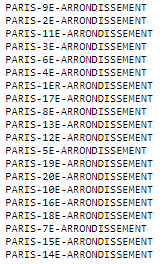

venues_in_Paris.head()

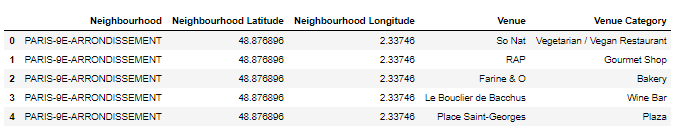

### Grouping by Venue Categories
We need to now see how many Venue Categories are there for further processing

venues_in_Paris.groupby('Venue Category').max()

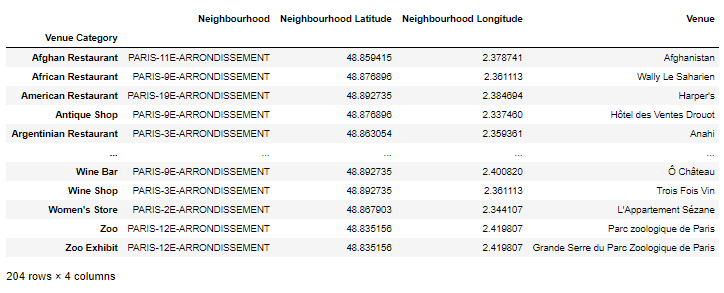

### One Hot Encoding 
We need to encode our venue categories to get a better result for our clustering

Paris_venue_cat = pd.get_dummies(venues_in_Paris[['Venue Category']], prefix="", prefix_sep="")
Paris_venue_cat

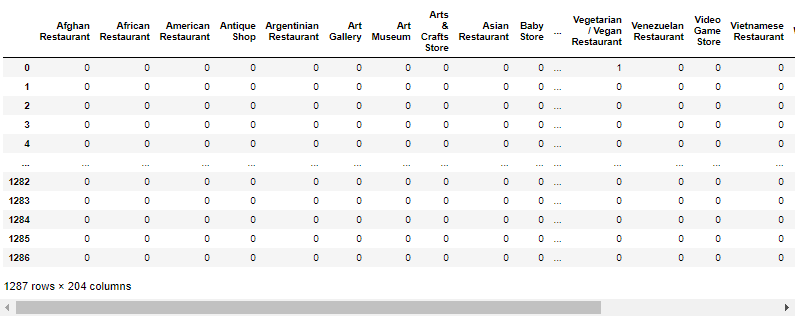

Paris_venue_cat['Neighbourhood'] = venues_in_Paris['Neighbourhood'] 

#moving neighborhood column to the first column
fixed_columns = [Paris_venue_cat.columns[-1]] + list(Paris_venue_cat.columns[:-1])
Paris_venue_cat = Paris_venue_cat[fixed_columns]

Paris_venue_cat.head()

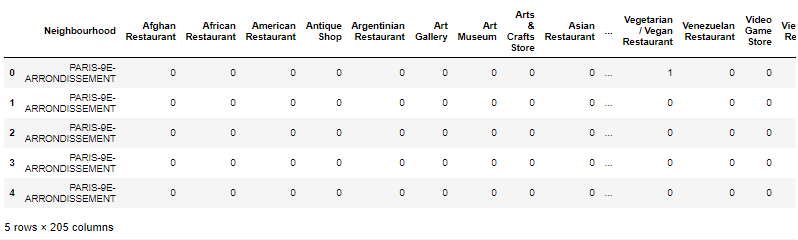

### Venue categories mean value
We will group the Neighbourhoods and calculate the mean venue categories value in each Neighbourhood

Paris_grouped = Paris_venue_cat.groupby('Neighbourhood').mean().reset_index()
Paris_grouped.head()

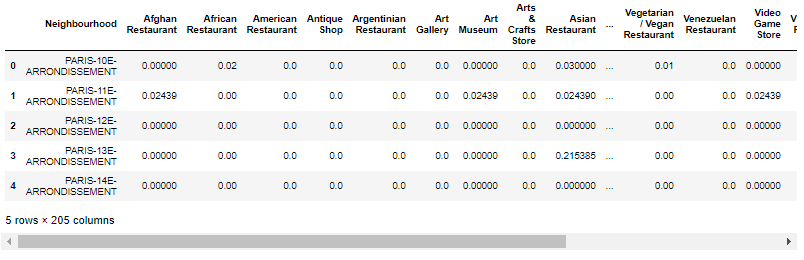

### Top venue categories
Using our defined function to get the top venue categories in the neighbourhoods of Paris.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

There are way too many venue categories, we can take the top 10 to cluster the neighbourhoods.
Creating a function to label the columns of the venue correctly

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

#create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

#create a new dataframe for Paris
neighborhoods_venues_sorted_paris = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_paris['Neighbourhood'] = Paris_grouped['Neighbourhood']

for ind in np.arange(Paris_grouped.shape[0]):
    neighborhoods_venues_sorted_paris.iloc[ind, 1:] = return_most_common_venues(Paris_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_paris.head()

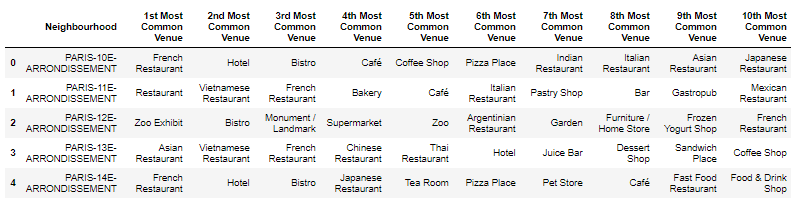

## Model Building

### K Means
Let's cluster the city of Paris to roughly 5 to make it easier to analyze. We use the K Means clustering technique to do so.

#set number of clusters
k_num_clusters = 5

Paris_grouped_clustering = Paris_grouped.drop('Neighbourhood', 1)

#run k-means clustering
kmeans_Paris = KMeans(n_clusters=k_num_clusters, random_state=0).fit(Paris_grouped_clustering)
kmeans_Paris

### Labelling Clustered Data

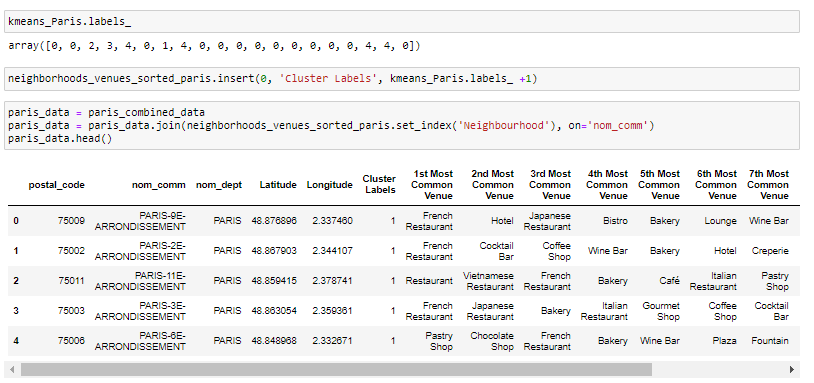

paris_data_nonan = paris_data.dropna(subset=['Cluster Labels'])

### Visualizing the clustered neighbourhood
Let's plot the clusters

map_clusters_paris = folium.Map(location=[paris_lat_coords, paris_lng_coords], zoom_start=12)

#set color scheme for the clusters
x = np.arange(k_num_clusters)
ys = [i + x + (i*x)**2 for i in range(k_num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_data_nonan['Latitude'], paris_data_nonan['Longitude'], paris_data_nonan['nom_comm'], paris_data_nonan['Cluster Labels']):
    label = folium.Popup('Cluster ' + str(int(cluster) +1) + ' ' + str(poi) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.8
        ).add_to(map_clusters_paris)
        
map_clusters_paris

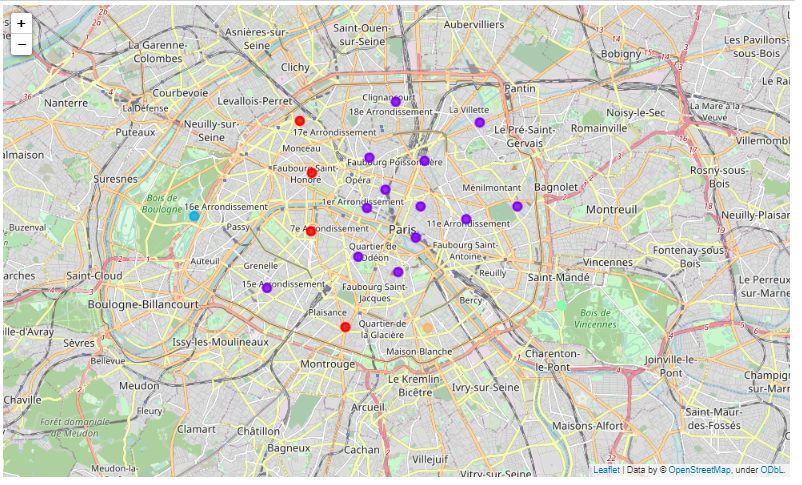

### Examining our Clusters

Cluster 1

paris_data_nonan.loc[paris_data_nonan['Cluster Labels'] == 1,
                     paris_data_nonan.columns[[1] + list(range(5, paris_data_nonan.shape[1]))]]

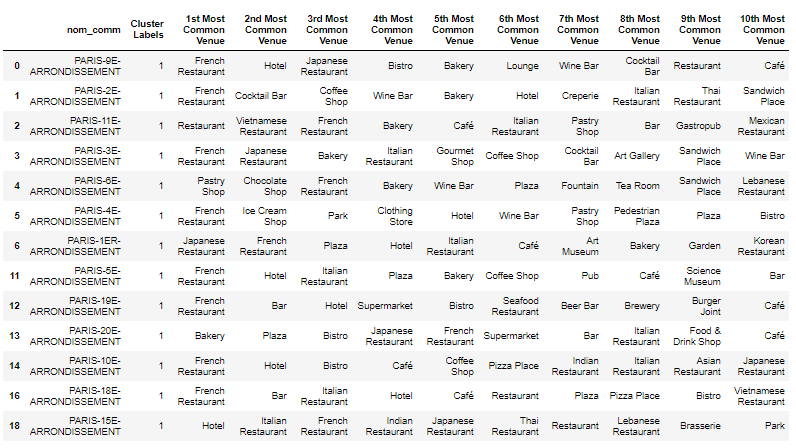

Cluster 2

paris_data_nonan.loc[paris_data_nonan['Cluster Labels'] == 2, 
                     paris_data_nonan.columns[[1] + list(range(5, paris_data_nonan.shape[1]))]]

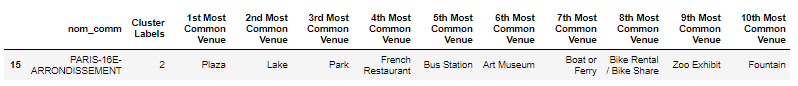

Cluster 3

paris_data_nonan.loc[paris_data_nonan['Cluster Labels'] == 3, 
                     paris_data_nonan.columns[[1] + list(range(5, paris_data_nonan.shape[1]))]]

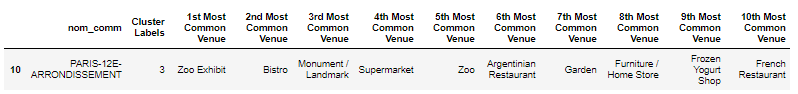

Cluster 4

paris_data_nonan.loc[paris_data_nonan['Cluster Labels'] == 4, 
                     paris_data_nonan.columns[[1] + list(range(5, paris_data_nonan.shape[1]))]]

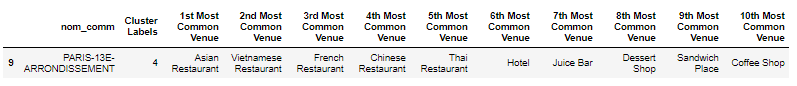

Cluster 5

paris_data_nonan.loc[paris_data_nonan['Cluster Labels'] == 5, 
                     paris_data_nonan.columns[[1] + list(range(5, paris_data_nonan.shape[1]))]]

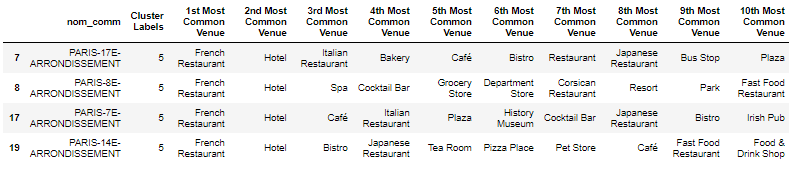

----------------------------------------
--------------------------------------

# Exploring London

### Data Collection
To get the neighbourhoods in london, we start by scraping the list of areas of london wiki page.

url_london = "https://en.wikipedia.org/wiki/List_of_areas_of_London"
wiki_london_url = requests.get(url_london)
wiki_london_url

output : <Response [200]>

wiki_london_data = pd.read_html(wiki_london_url.text)
wiki_london_data

wiki_london_data = wiki_london_data[1]
wiki_london_data

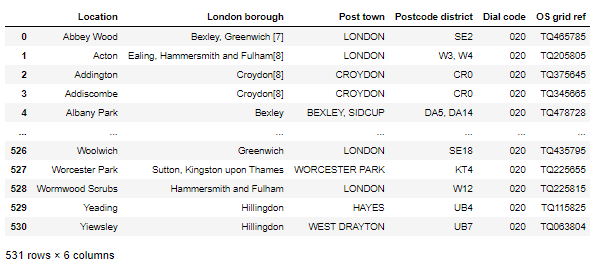

### Data Preprocessing
we remove the spaces in the column titles and then we add _ between words.

wiki_london_data.rename(columns=lambda x: x.strip().replace(" ", "_"), inplace=True)
wiki_london_data

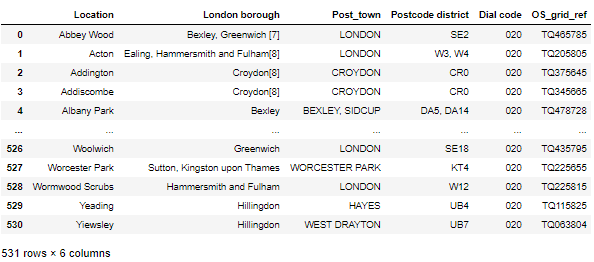

### Feature Selection
We need only the boroughs, postal codes, post town for further steps. We can drop the locations, dial codes and OS grid.

df_london = wiki_london_data.drop( [ wiki_london_data.columns[0], 
                              wiki_london_data.columns[4], 
                              wiki_london_data.columns[5] ], axis=1)
df_london.head()

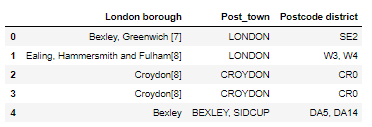

df_london.columns = ['borough','town','post_code']
df_london

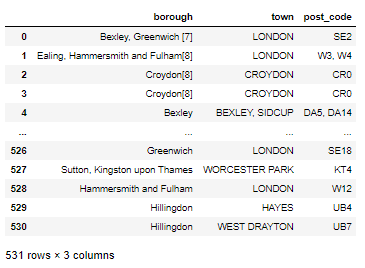

df_london['borough'] = df_london['borough'].map(lambda x: x.rstrip(']').rstrip('0123456789').rstrip('['))
df_london

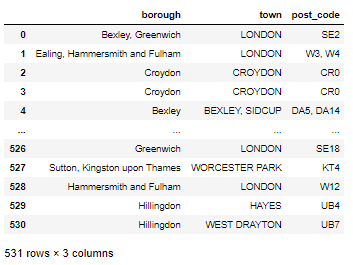

### Feature Engineering
We can only focusing on the neighbourhoods of London, so performing the changes

df_london = df_london[df_london['town'].str.contains('LONDON')]
df_london

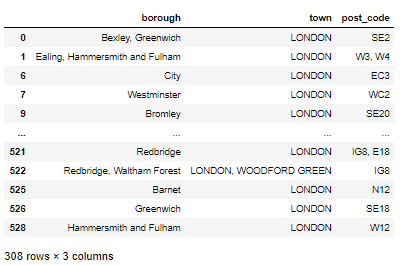

def get_x_y_uk(address1):
   lat_coords = 0
   lng_coords = 0
   g = geocode(address='{}, London, England, GBR'.format(address1))[0]
   lng_coords = g['location']['x']
   lat_coords = g['location']['y']
   return str(lat_coords) +","+ str(lng_coords)

geo_coordinates_uk = df_london['post_code']    
geo_coordinates_uk

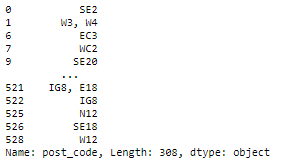

coordinates_latlng_uk = geo_coordinates_uk.apply(lambda x: get_x_y_uk(x))
coordinates_latlng_uk

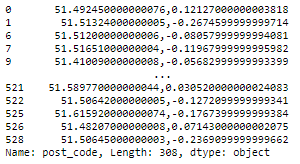

#### Latitude
Extracting the latitude from our previously collected coordinates

lat_uk = coordinates_latlng_uk.apply(lambda x: x.split(',')[0])
lat_uk

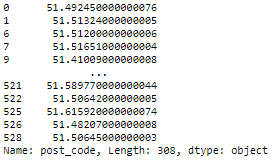

#### Longitude
Extracting the Longitude from our previously collected coordinates

lng_uk = coordinates_latlng_uk.apply(lambda x: x.split(',')[1])
lng_uk

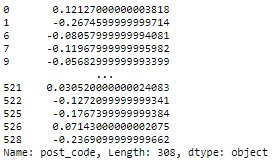

london_merged = pd.concat([df_london,lat_uk.astype(float), lng_uk.astype(float)], axis=1)
london_merged.columns= ['borough','town','post_code','latitude','longitude']
london_merged

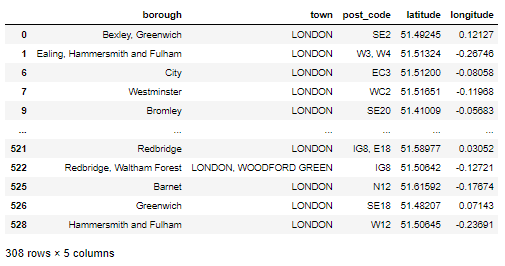

### Visualize the Map of London
To help visualize the Map of London and the neighbourhoods in London, we make use of the folium package.

london = geocode(address='London, England, GBR')[0]
london_lng_coords = london['location']['x']
london_lat_coords = london['location']['y']
print(london_lng_coords, london_lat_coords)

output : -0.1272099999999341 51.50642000000005

#Creating the map of London
map_London = folium.Map(location=[london_lat_coords, london_lng_coords], zoom_start=12)
map_London

#adding markers to map
for latitude, longitude, borough, town in zip(london_merged['latitude'], london_merged['longitude'], london_merged['borough'], london_merged['town']):
    label = '{}, {}'.format(town, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='red',
        fill=True
        ).add_to(map_London)  
    
map_London

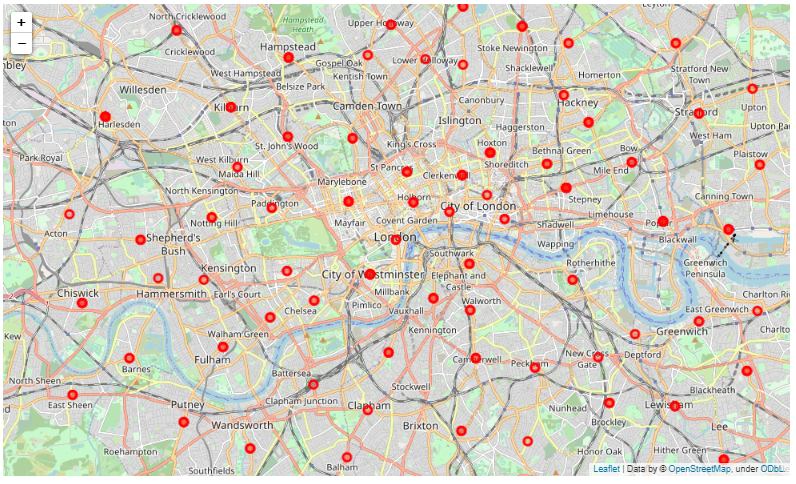

### Venues in London
Using our previously defined function. Let's get the neaby venues present in each neighbourhood of London

venues_in_London = getNearbyVenues(london_merged['borough'], 
                                   london_merged['latitude'], 
                                   london_merged['longitude'])

venues_in_London.head()

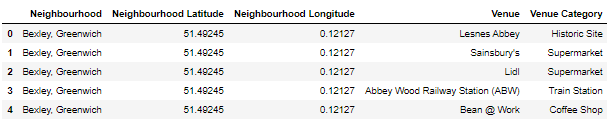

### Grouping by Venue Categories
We need to now see how many Venue Categories are there for further processing

venues_in_London.groupby('Venue Category').max()

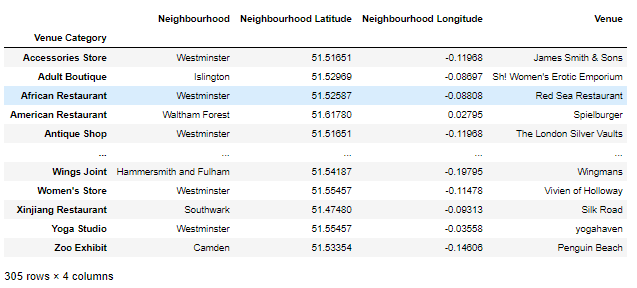

We can see 305 records, just goes to show how diverse and interesting the place is.

### One Hot Encoding 
We need to Encode our venue categories to get a better result for our clustering

London_venue_cat = pd.get_dummies(venues_in_London[['Venue Category']], prefix="", prefix_sep="")
London_venue_cat

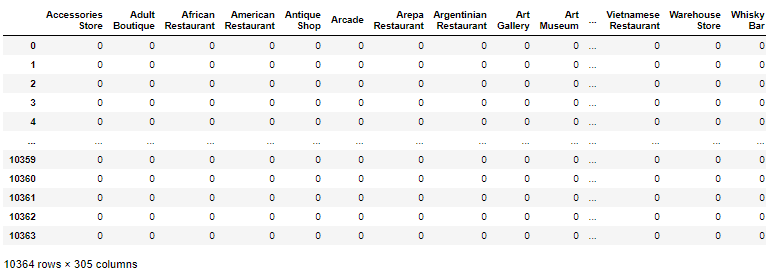

London_venue_cat['Neighbourhood'] = venues_in_London['Neighbourhood'] 

#moving neighborhood column to the first column
fixed_columns = [London_venue_cat.columns[-1]] + list(London_venue_cat.columns[:-1])
London_venue_cat = London_venue_cat[fixed_columns]

London_venue_cat.head()

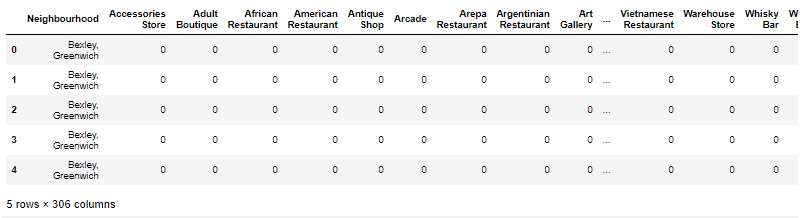

### Venue categories mean value
We will group the Neighbourhoods and calculate the mean venue categories value in each Neighbourhood

London_grouped = London_venue_cat.groupby('Neighbourhood').mean().reset_index()
London_grouped.head()

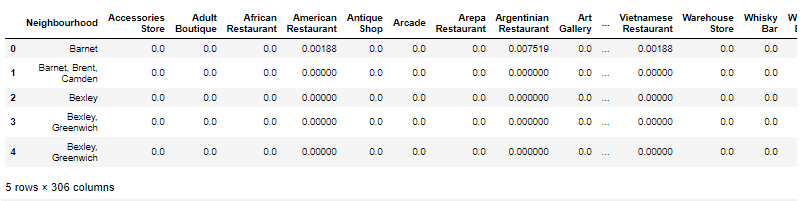

### Top venue categories
Getting the top venue categories in London

#create a new dataframe for London
neighborhoods_venues_sorted_london = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_london['Neighbourhood'] = London_grouped['Neighbourhood']

for ind in np.arange(London_grouped.shape[0]):
    neighborhoods_venues_sorted_london.iloc[ind, 1:] = return_most_common_venues(London_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_london.head()

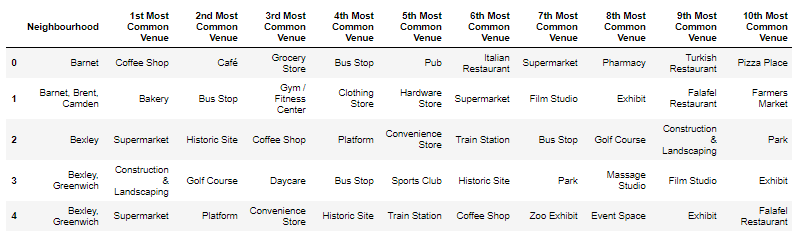

## Model Building

### K Means
Let's cluster the city of london to roughly 5 to make it easier to analyze. We use the K Means clustering technique to do so.

#set number of clusters
k_num_clusters = 5

London_grouped_clustering = London_grouped.drop('Neighbourhood', 1)

#run k-means clustering
kmeans_london = KMeans(n_clusters=k_num_clusters, random_state=0).fit(London_grouped_clustering)
kmeans_london

### Labelling Clustered Data

kmeans_london.labels_

neighborhoods_venues_sorted_london.insert(0, 'Cluster Labels', kmeans_london.labels_ +1)

london_data = london_merged
london_data = london_data.join(neighborhoods_venues_sorted_london.set_index('Neighbourhood'), on='borough')
london_data.head()

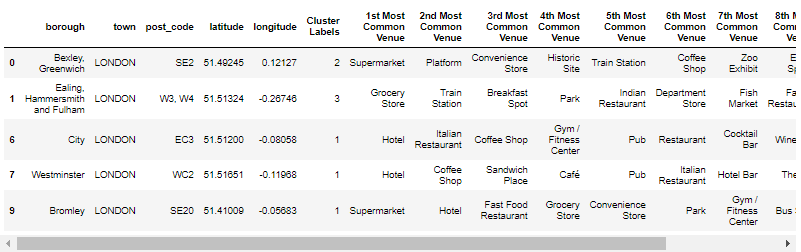

london_data_nonan = london_data.dropna(subset=['Cluster Labels'])

### Visualizing the clustered neighbourhood
Let's plot the clusters

map_clusters_london = folium.Map(location=[london_lat_coords, london_lng_coords], zoom_start=11)

#set color scheme for the clusters
x = np.arange(k_num_clusters)
ys = [i + x + (i*x)**2 for i in range(k_num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_data_nonan['latitude'], london_data_nonan['longitude'], london_data_nonan['borough'], london_data_nonan['Cluster Labels']):
    label = folium.Popup('Cluster ' + str(int(cluster) +1) + '\n' + str(poi) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.8
        ).add_to(map_clusters_london)
        
map_clusters_london

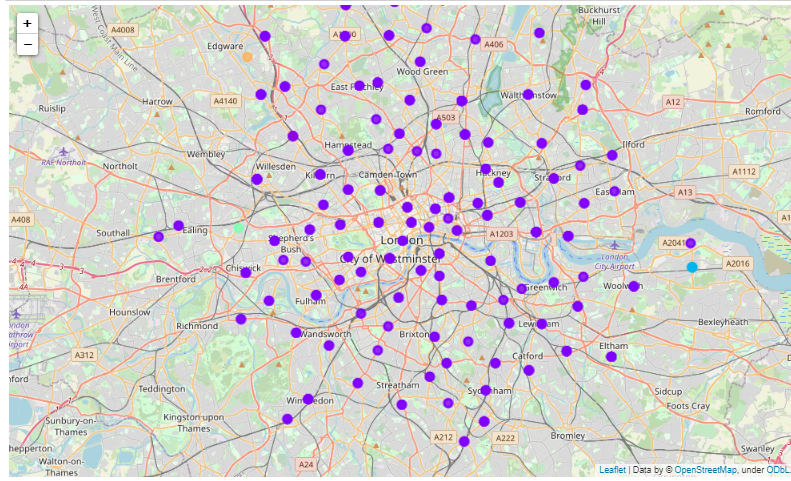

## Examining our Clusters

Cluster 1

london_data_nonan.loc[london_data_nonan['Cluster Labels'] == 1, 
                      london_data_nonan.columns[[1] + list(range(5, london_data_nonan.shape[1]))]]

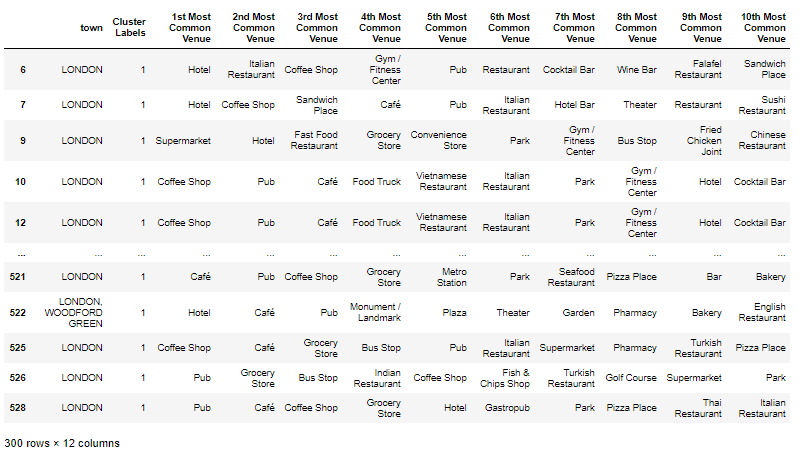

Cluster 2

london_data_nonan.loc[london_data_nonan['Cluster Labels'] == 2, 
                      london_data_nonan.columns[[1] + list(range(5, london_data_nonan.shape[1]))]]

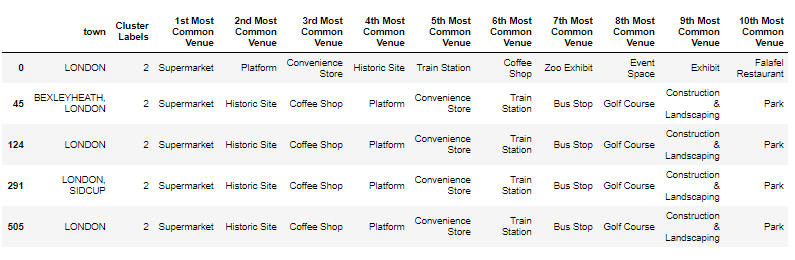

Cluster 3

london_data_nonan.loc[london_data_nonan['Cluster Labels'] == 3,
                      london_data_nonan.columns[[1] + list(range(5, london_data_nonan.shape[1]))]]

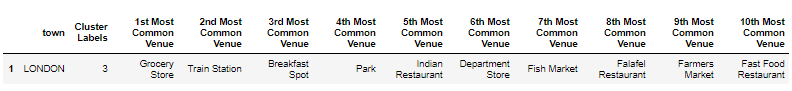

Cluster 4

london_data_nonan.loc[london_data_nonan['Cluster Labels'] == 4,
                      london_data_nonan.columns[[1] + list(range(5, london_data_nonan.shape[1]))]]

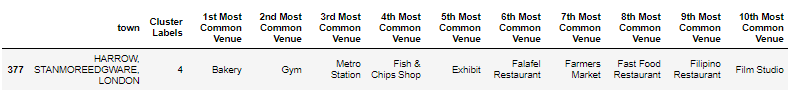

Cluster 5

london_data_nonan.loc[london_data_nonan['Cluster Labels'] == 5,
                      london_data_nonan.columns[[1] + list(range(5, london_data_nonan.shape[1]))]]

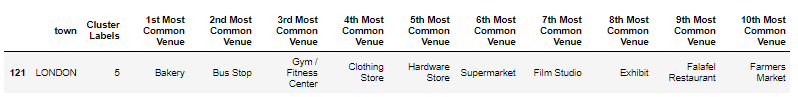

# 4. Results and Discussion

Paris is relatively smaller in size geographically. There are a lot of hangout spots including many restaurants, bars, and bistro. There are public transport in Paris such as buses, bikes, boats or ferries. For leisure and sight seeing, there are a lot of plazas, trails, parks, historic sites, clothing shops, art galleries and museums. It has a wide variety of cusines and eateries including French, Thai, Cambodian, Asian, Chinese etc. Overall, Paris seems like the relaxing vacation spot with a mix of lakes, historic spots and a wide variety of cusines to try out.

The neighbourhoods of London are very multicultural. There are a lot of different cusines including Indian, Italian, Turkish and Chinese. London seems takes a step further by having a lot of restaurants, bars, juice bars, coffee shops, fish and chips shop and breakfast spots. It has a lot of shopping options such as lea markets, flower shops, fish markets, fishing stores, clothing stores. The public transport such as buses and trains. For leisure, the neighbourhoods are set up to have lots of parks, golf courses, zoo, gyms and historic sites. Overall, London offers a multicultural, diverse and certainly an entertaining experience.


# 5. Conclusion

The purpose of this project was to explore the cities of Paris and London and see how attractive it is to potential tourists and migrants. We explored both the cities based on their postal codes and then extrapolated the common venues present in each of the neighbourhoods finally concluding with clustering similar neighbourhoods together. We could see that each of the neighbourhoods in both the cities have a wide variety of experiences to offer which is unique in it's own way.

Both Paris and London seem to offer a vacation stay or a romantic gateaway with a lot of places to explore, beautiful landscapes and a wide variety of culture. Overall, it's up to the stakeholders to decide which experience they would prefer more and which would more to their liking.